In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/bout")

In [3]:
from core import SITE_NAMES, FREQ_GROUPS
import clustering as clstr
import bout.assembly as bt
import bout.clustering as clstr
import plot as bt_plt
import activity.subsampling as ss
import activity.activity_assembly as actvt
import pipeline

from cli import get_file_paths

Looking at Telephone Field
Telephone HF Min: 26880.0
Telephone HF Max: 76800.0
Telephone HF Mean: 46630.902257676535
Telephone HF Median: 46080.0
Telephone HF Mode: 46080.0


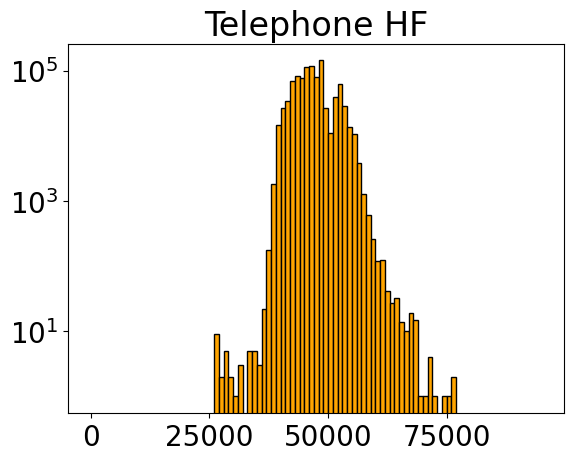

In [26]:
site_key = 'Telephone'
freq_key = 'HF'

bout_params = dict()
bout_params['site_key'] = site_key
bout_params['freq_key'] = freq_key

fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
fig_details['freq_group'] = freq_key.split('_')[0].upper()
if freq_key:
    fig_details['freq_group'] = fig_details['freq_group'] + ' '
fig_details['bin_step'] = 10
fig_details['time_end'] = 1000
print(f'Looking at {fig_details["site_name"]}')
location_df = pd.read_csv(f'../data/2022_detector_summaries/{bout_params["site_key"]}/bd2__{bout_params["freq_key"]}{bout_params["site_key"]}_2022_kmeans.csv', index_col=0, dtype='object')

stat_arr = location_df.peak_frequency.astype(float)
print(f"{site_key} {freq_key} Min: {stat_arr.min()}")
print(f"{site_key} {freq_key} Max: {stat_arr.max()}")
print(f"{site_key} {freq_key} Mean: {stat_arr.mean()}")
print(f"{site_key} {freq_key} Median: {stat_arr.median()}")
print(f"{site_key} {freq_key} Mode: {stat_arr.mode().item()}")

plt.figure()
plt.title(f'{site_key} {freq_key}')
plt.hist(stat_arr, bins=np.arange(0, 96000, 1000), facecolor='orange', edgecolor='k')
plt.yscale('log')
plt.show()

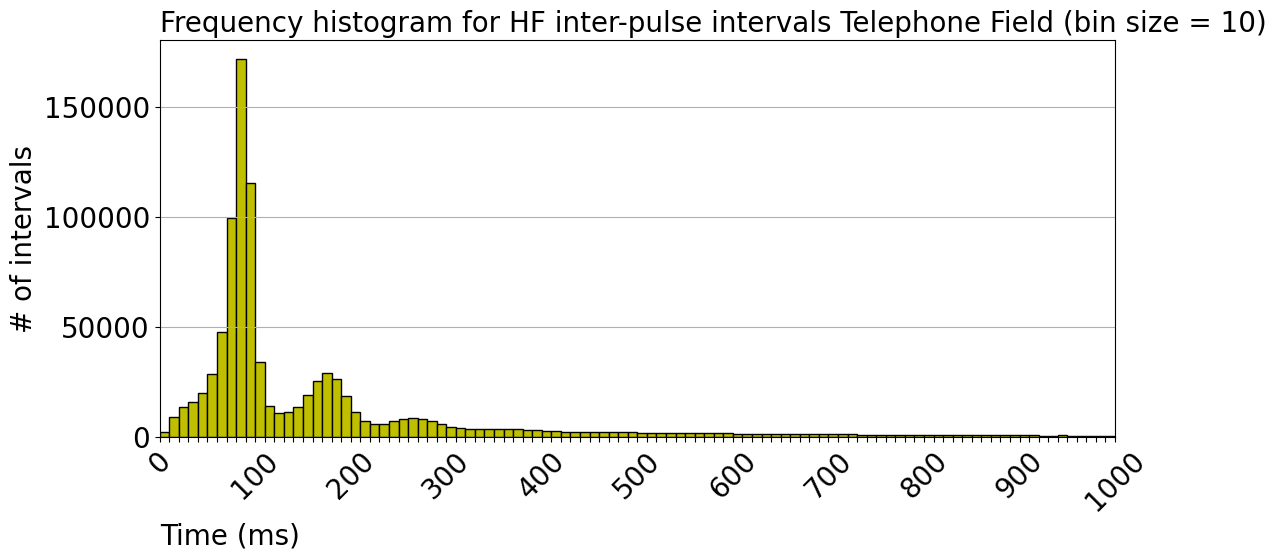

In [5]:
ipis_f, hist_f = bt_plt.plot_ipi_hist(location_df.copy(), fig_details)

In [6]:
location_df = pd.read_csv(f'../data/2022_detector_summaries/{bout_params["site_key"]}/bd2__{bout_params["freq_key"]}{bout_params["site_key"]}_2022_kmeans.csv', index_col=0)
ipis_loc, hist_loc = clstr.get_histogram(location_df, fig_details['bin_step'])
intervals_ms, survival = clstr.get_log_survival(hist_loc)

fast_process = clstr.regress_around_fast_intervals(intervals_ms, survival, hist_loc[0])
fast_process = clstr.calculate_exponential_coefficients(fast_process)

slow_process = clstr.regress_around_slow_intervals(intervals_ms, survival)
slow_process = clstr.calculate_exponential_coefficients(slow_process)

fg_bci, misassigned_points_fg = clstr.get_bci_from_fagenyoung_method(fast_process, slow_process)
print(f"Fagen&Young method has {round(misassigned_points_fg)} missassigned points")
bci, misassigned_points = clstr.get_bci_from_slater_method(intervals_ms, survival, fast_process, slow_process)
print(f"Slater method has {round(misassigned_points)} missassigned points")
nlin_results, misassigned_points_optim = clstr.get_bci_from_sibly_method(intervals_ms, survival, fast_process, slow_process)
print(f"Sibly method has {round(misassigned_points_optim)} missassigned points")
print(f"Optim BCI has less misassignments than BCI? {misassigned_points_optim < misassigned_points}")
if misassigned_points_optim < misassigned_points:
    print(f"{int(misassigned_points - misassigned_points_optim)} more points assigned correctly")

/var/folders/qj/4txkrxcn2ld7mby9_6n6npnr0000gn/T/ipykernel_85906/1452210673.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  location_df = pd.read_csv(f'../data/2022_detector_summaries/{bout_params["site_key"]}/bd2__{bout_params["freq_key"]}{bout_params["site_key"]}_2022_kmeans.csv', index_col=0)


Fagen&Young method has 827327557 missassigned points
Slater method has 1811795 missassigned points
Sibly method has 2523114 missassigned points
Optim BCI has less misassignments than BCI? False


In [7]:
fast_process, slow_process

({'metrics': LinregressResult(slope=-0.0014422665209737095, intercept=12.520118969019869, rvalue=-0.911267894910033, pvalue=1.3104349860790488e-78, stderr=4.620341635829439e-05, intercept_stderr=0.053417757002528043),
  'indices': array([ True,  True,  True, ..., False, False, False]),
  'lambda': 0.0014422665209737095,
  'num_intervals_slater': 189833588.9876326},
 {'metrics': LinregressResult(slope=-4.1100894481580396e-07, intercept=5.8290603942623385, rvalue=-0.9531973138953582, pvalue=0.0, stderr=1.1470689562277491e-10, intercept_stderr=0.0008614358524761815),
  'indices': array([False, False, False, ..., False, False, False]),
  'lambda': 4.1100894481580396e-07,
  'num_intervals_slater': 827327557.1988497})

In [8]:
nlin_results

{'solution': array([7.96529627e+08, 1.20401117e-03, 8.27327560e+08, 4.11008945e-07]),
 'fast_num_intervals': 796529627.059609,
 'fast_lambda': 0.0012040111748771985,
 'slow_num_intervals': 827327559.6913469,
 'slow_lambda': 4.110089453001611e-07,
 'bci': 6600.711813543369}

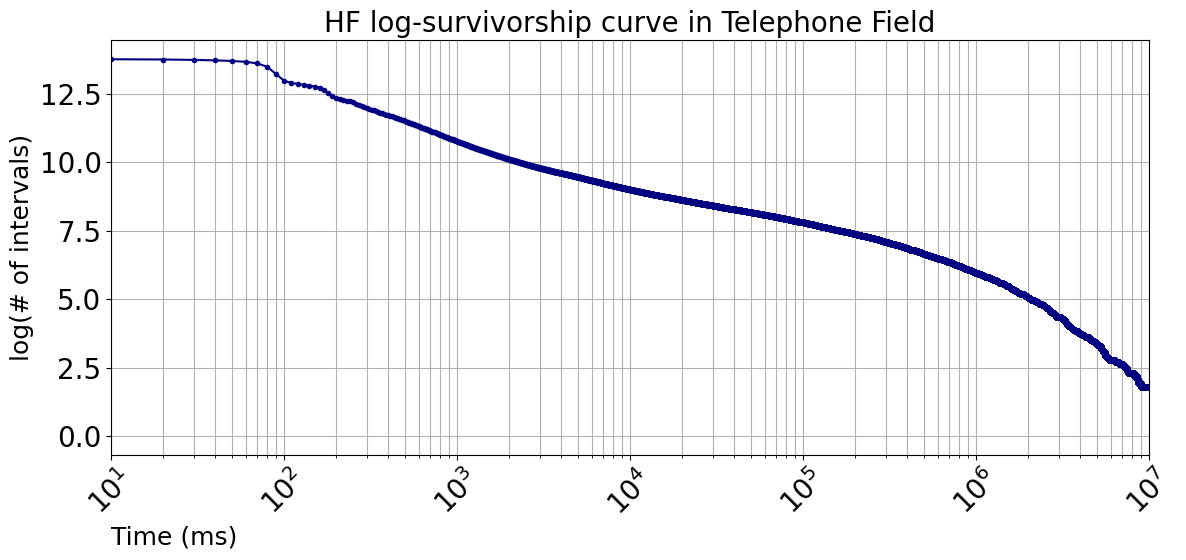

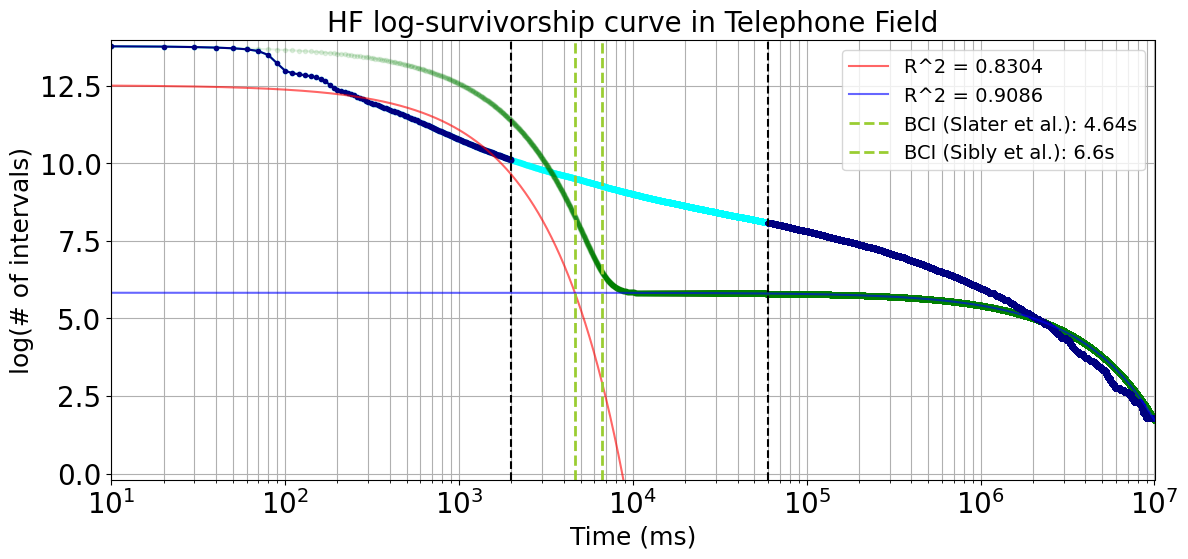

In [9]:
bt_plt.plot_log_survival(intervals_ms, survival, fig_details)
fig_details['time_end'] = 60000
fig_details['site_name'] = SITE_NAMES[site_key]
bt_plt.plot_nlin_results_over_survival(intervals_ms, survival, fast_process, slow_process, nlin_results['solution'], nlin_results['bci'], bci, fig_details)

Looking at Telephone Field
Telephone LF Min: 13440.0
Telephone LF Max: 40320.0
Telephone LF Mean: 27250.81545064378
Telephone LF Median: 26880.0
Telephone LF Mode: 26880.0


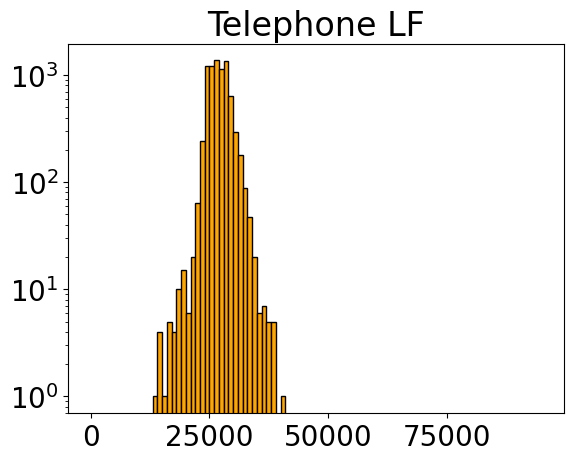

In [25]:
site_key = 'Telephone'
freq_key = 'LF'

bout_params = dict()
bout_params['site_key'] = site_key
bout_params['freq_key'] = freq_key

fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
fig_details['freq_group'] = freq_key.split('_')[0].upper()
if freq_key:
    fig_details['freq_group'] = fig_details['freq_group'] + ' '
fig_details['bin_step'] = 10
fig_details['time_end'] = 1000
print(f'Looking at {fig_details["site_name"]}')
location_df = pd.read_csv(f'../data/2022_detector_summaries/{bout_params["site_key"]}/bd2__{bout_params["freq_key"]}{bout_params["site_key"]}_2022_kmeans.csv', index_col=0, dtype='object')

stat_arr = location_df.peak_frequency.astype(float)
print(f"{site_key} {freq_key} Min: {stat_arr.min()}")
print(f"{site_key} {freq_key} Max: {stat_arr.max()}")
print(f"{site_key} {freq_key} Mean: {stat_arr.mean()}")
print(f"{site_key} {freq_key} Median: {stat_arr.median()}")
print(f"{site_key} {freq_key} Mode: {stat_arr.mode().item()}")

plt.figure()
plt.title(f'{site_key} {freq_key}')
plt.hist(stat_arr, bins=np.arange(0, 96000, 1000), facecolor='orange', edgecolor='k')
plt.yscale('log')
plt.show()

Telephone LF Max: 40320.0
Telephone LF Median: 26880.0
Telephone LF Mean: 27250.81545064378


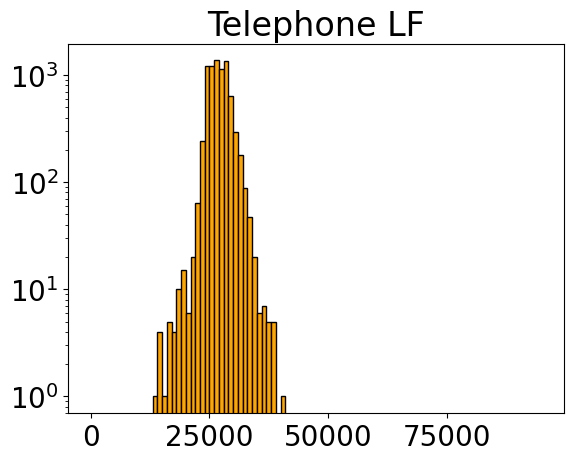

In [20]:
stat_arr = location_df.peak_frequency.astype(float)
print(f"{site_key} {freq_key} Max: {stat_arr.max()}")
print(f"{site_key} {freq_key} Median: {stat_arr.median()}")
print(f"{site_key} {freq_key} Mean: {stat_arr.mean()}")

plt.figure()
plt.title(f'{site_key} {freq_key}')
plt.hist(stat_arr, bins=np.arange(0, 96000, 1000), facecolor='orange', edgecolor='k')
plt.yscale('log')
plt.show()

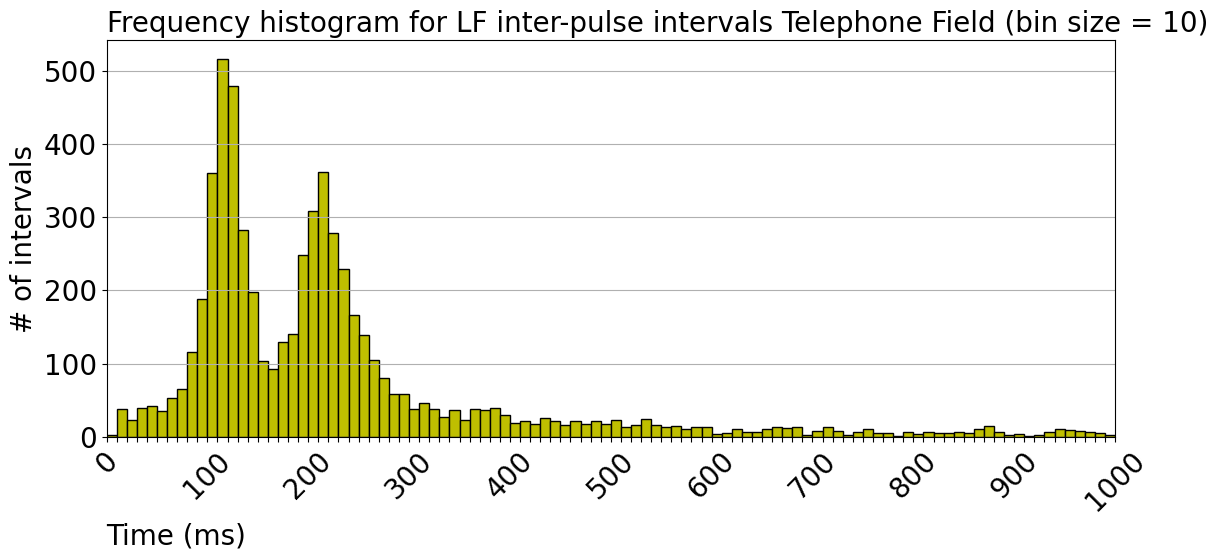

In [11]:
ipis_f, hist_f = bt_plt.plot_ipi_hist(location_df.copy(), fig_details)

In [12]:
location_df = pd.read_csv(f'../data/2022_detector_summaries/{bout_params["site_key"]}/bd2__{bout_params["freq_key"]}{bout_params["site_key"]}_2022_kmeans.csv', index_col=0)
ipis_loc, hist_loc = clstr.get_histogram(location_df, fig_details['bin_step'])
intervals_ms, survival = clstr.get_log_survival(hist_loc)

fast_process = clstr.regress_around_fast_intervals(intervals_ms, survival, hist_loc[0])
fast_process = clstr.calculate_exponential_coefficients(fast_process)

slow_process = clstr.regress_around_slow_intervals(intervals_ms, survival)
slow_process = clstr.calculate_exponential_coefficients(slow_process)

fg_bci, misassigned_points_fg = clstr.get_bci_from_fagenyoung_method(fast_process, slow_process)
print(f"Fagen&Young method has {round(misassigned_points_fg)} missassigned points")
bci, misassigned_points = clstr.get_bci_from_slater_method(intervals_ms, survival, fast_process, slow_process)
print(f"Slater method has {round(misassigned_points)} missassigned points")
nlin_results, misassigned_points_optim = clstr.get_bci_from_sibly_method(intervals_ms, survival, fast_process, slow_process)
print(f"Sibly method has {round(misassigned_points_optim)} missassigned points")
print(f"Optim BCI has less misassignments than BCI? {misassigned_points_optim < misassigned_points}")
if misassigned_points_optim < misassigned_points:
    print(f"{int(misassigned_points - misassigned_points_optim)} more points assigned correctly")

Fagen&Young method has 1681022428 missassigned points
Slater method has 1577483 missassigned points
Sibly method has 1578928 missassigned points
Optim BCI has less misassignments than BCI? False


In [13]:
fast_process, slow_process

({'metrics': LinregressResult(slope=-0.0005686592398337955, intercept=8.297654645774942, rvalue=-0.8081467295714576, pvalue=1.2402913543070136e-47, stderr=2.9378984540206837e-05, intercept_stderr=0.033966307707201986),
  'indices': array([ True,  True,  True, ..., False, False, False]),
  'lambda': 0.0005686592398337955,
  'num_intervals_slater': 7059493.21646278},
 {'metrics': LinregressResult(slope=-1.388191468951243e-07, intercept=5.452574181010638, rvalue=-0.9932955754658779, pvalue=0.0, stderr=8.87313802239356e-12, intercept_stderr=0.00017030020136762341),
  'indices': array([False, False, False, ..., False, False, False]),
  'lambda': 1.388191468951243e-07,
  'num_intervals_slater': 1681022428.2110283})

In [14]:
nlin_results

{'solution': array([1.15100435e+07, 6.63040485e-04, 1.68102243e+09, 1.38819147e-07]),
 'fast_num_intervals': 11510043.496363824,
 'fast_lambda': 0.0006630404852164029,
 'slow_num_intervals': 1681022429.0492308,
 'slow_lambda': 1.388191469305377e-07,
 'bci': 5260.933937069897}

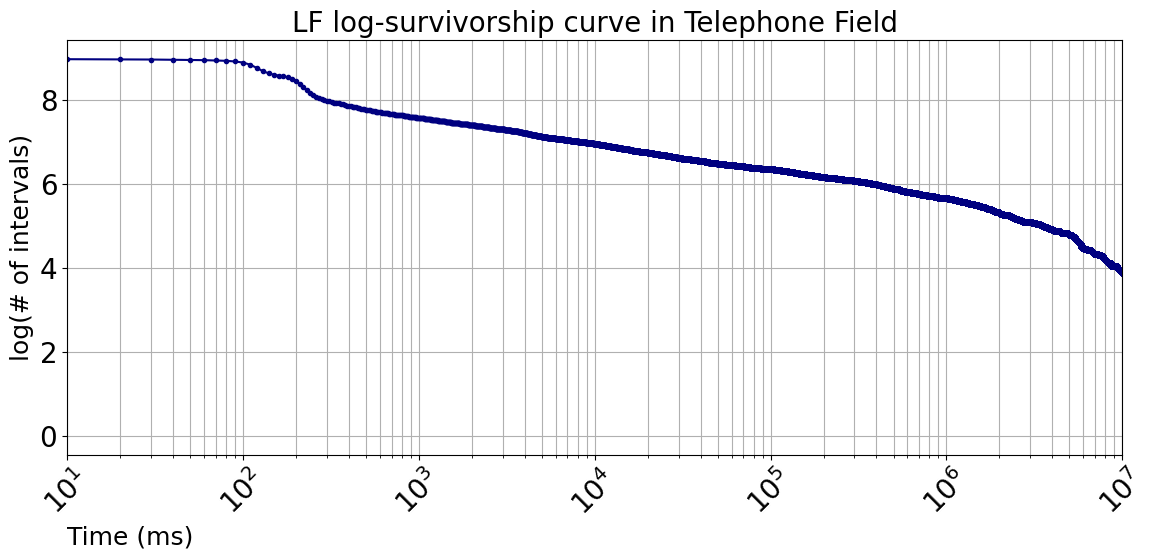

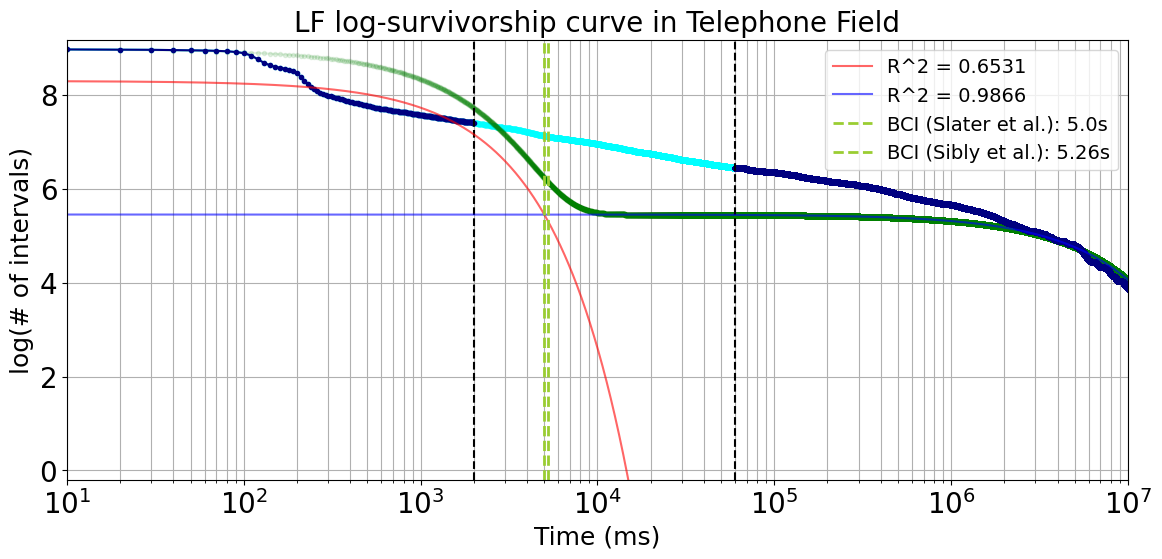

In [15]:
bt_plt.plot_log_survival(intervals_ms, survival, fig_details)
fig_details['time_end'] = 60000
fig_details['site_name'] = SITE_NAMES[site_key]
bt_plt.plot_nlin_results_over_survival(intervals_ms, survival, fast_process, slow_process, nlin_results['solution'], nlin_results['bci'], bci, fig_details)